<a href="https://colab.research.google.com/github/Alafiade/ConvModels-for-Image-classification/blob/main/Pruned_EfficientNetb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


IMPORTING DEPENDENCIES




In [16]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
plt.ion()
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

DOWNLOADING DATASET FROM KAGGLE

In [2]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
100% 195M/195M [00:11<00:00, 22.1MB/s]
100% 195M/195M [00:11<00:00, 18.5MB/s]


In [3]:
!unzip breast.zip

Archive:  breast.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/be

In [37]:
!pip install split-folders # Install splitfolders using pip
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.utils.data as data
import splitfolders # Import splitfolders


# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define data directories
data_dir = "/content/Dataset_BUSI_with_GT"  # Replace with the actual path to your data directory
output_dir = "/content/sample_data" # Define output directory for split data

# Split the data into train and val sets using splitfolders
# This will create 'train' and 'val' directories inside output_dir
splitfolders.ratio(data_dir, output=output_dir, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Update train_dir and val_dir to point to the newly created directories
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Create ImageFolder datasets
image_datasets = {
    'Training': datasets.ImageFolder(train_dir, transform=transform),
    'Validation': datasets.ImageFolder(val_dir, transform=transform)
}

# Create DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2)
    for x in ['Training', 'Validation']
}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Copying files: 1578 files [00:00, 2297.27 files/s]


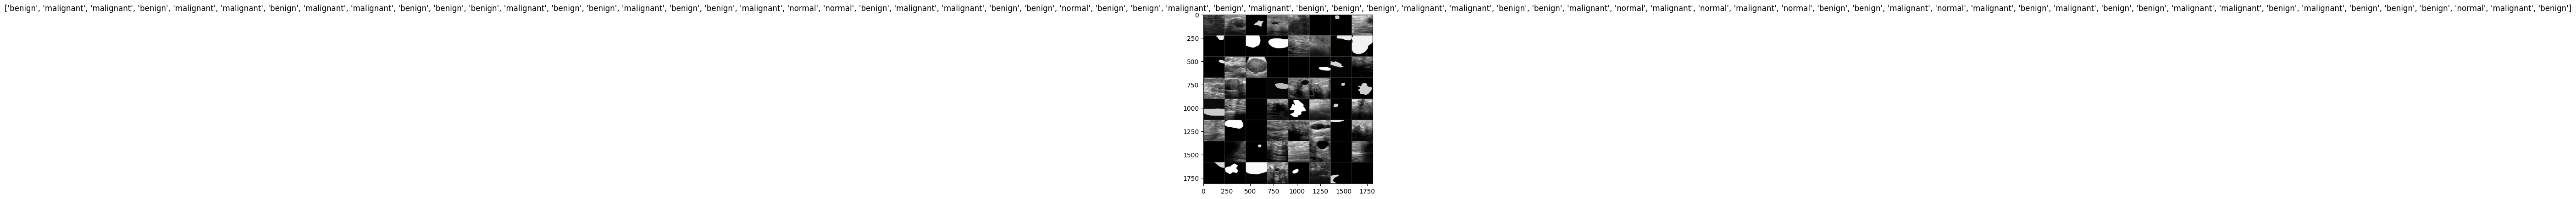

In [5]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp +mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['Validation']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

IMPORTING THE EFFICIENTNET MODEL

In [34]:
from torchvision.models import efficientnet_b2
model = efficientnet_b2(pretrained =True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 165MB/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [46]:
import torch.optim as optim
optimizer = optim.SGD(model.classifier[-1].parameters(), lr= 0.001, momentum= 0.9, weight_decay= 0.01)

Learning Rate Scheduler

In [47]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [45]:
torch.nn.Dropout(p=0.3)

Dropout(p=0.3, inplace=False)

In [39]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

Pruned Model


In [13]:
import torch.nn.utils.prune as prune

In [43]:
model.cpu()

for module in model.named_modules():
  if isinstance(module, torch.nn.Conv2d):
    prune.l1_unstructured(module, name='weight', amount=0.1)
    prune.remove(module,'weight')

model.cuda()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)



                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc: # Changed 'Test' to 'Validation'
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
Training Loss: 0.9535 Acc: 0.7246
Validation Loss: 1.0375 Acc: 0.7358
Epoch 2/20
----------
Training Loss: 0.9874 Acc: 0.7119
Validation Loss: 0.9906 Acc: 0.7421
Epoch 3/20
----------
Training Loss: 0.9139 Acc: 0.7325
Validation Loss: 1.0974 Acc: 0.7264
Epoch 4/20
----------
Training Loss: 0.9314 Acc: 0.7095
Validation Loss: 0.8937 Acc: 0.7453
Epoch 5/20
----------
Training Loss: 0.9343 Acc: 0.7159
Validation Loss: 0.8778 Acc: 0.7453
Epoch 6/20
----------
Training Loss: 0.9181 Acc: 0.7190
Validation Loss: 0.8576 Acc: 0.7610
Epoch 7/20
----------
Training Loss: 0.8971 Acc: 0.7325
Validation Loss: 0.8544 Acc: 0.7201
Epoch 8/20
----------
Training Loss: 0.9157 Acc: 0.7119
Validation Loss: 0.8806 Acc: 0.7327
Epoch 9/20
----------
Training Loss: 0.8706 Acc: 0.7222
Validation Loss: 0.8607 Acc: 0.7830
Epoch 10/20
----------
Training Loss: 0.8127 Acc: 0.7421
Validation Loss: 0.9350 Acc: 0.7358
Epoch 11/20
----------
Training Loss: 0.8574 Acc: 0.7151
Validation Loss: 0.857

In [29]:
torch.cuda.empty_cache()

FREEZING AND REPLACING ALL CLASSIFICATION HEAD

In [ ]:
import torch.nn as nn

for param in model.parameters():
    param.requires_grad = False

num_classes = 3

# Get the last layer of the classifier
last_layer = model.classifier[-1]  # Assuming it's a Linear layer
# Check if the last layer is a Linear layer
if isinstance(last_layer, nn.Linear):
    # Replace the last layer with a new Linear layer
    model.classifier[-1] = nn.Linear(last_layer.in_features, num_classes)
else:
    print("Warning: The last layer of the classifier is not a Linear layer. Modification skipped.")

UNFREEZING THE WHOLE LAYERS

In [ ]:
for param in model.parameters():
  param.requires_grad = True

In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


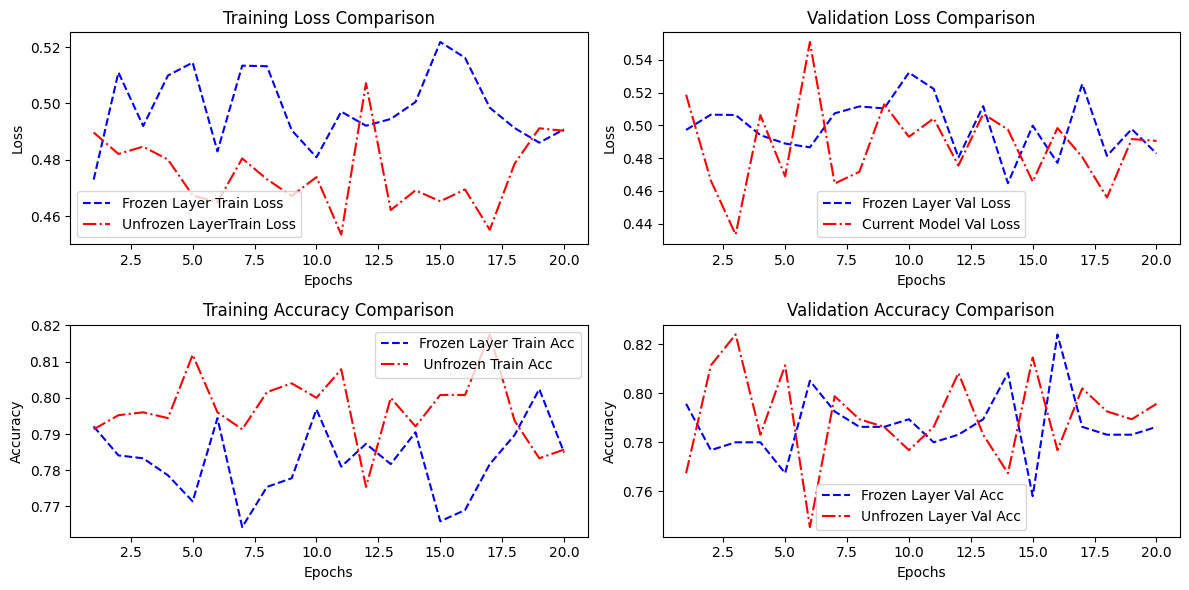

In [ ]:
import matplotlib.pyplot as plt

# Example logs for frozen layers (you will replace these with the actual logs)
frozen_train_loss = [0.4730, 0.5110, 0.4920, 0.5099, 0.5145, 0.4830, 0.5134, 0.5132, 0.4905, 0.4809, 0.4971, 0.4921, 0.4945, 0.5005, 0.5218, 0.5162, 0.4985, 0.4913, 0.4861, 0.4908]
frozen_val_loss = [0.4972, 0.5065, 0.5063, 0.4940, 0.4889, 0.4866, 0.5073, 0.5115, 0.5103, 0.5321, 0.5222, 0.4804, 0.5117, 0.4647, 0.4998, 0.4771, 0.5252, 0.4814, 0.4977, 0.4828]
frozen_train_acc = [0.7921, 0.7841, 0.7833, 0.7786, 0.7714, 0.7944, 0.7643, 0.7754, 0.7778, 0.7968, 0.7810, 0.7873, 0.7817, 0.7905, 0.7659, 0.7690, 0.7817, 0.7897, 0.8024, 0.7849]
frozen_val_acc = [0.7956, 0.7767, 0.7799, 0.7799, 0.7673, 0.8050, 0.7925, 0.7862, 0.7862, 0.7893, 0.7799, 0.7830, 0.7893, 0.8082, 0.7579, 0.8239, 0.7862, 0.7830, 0.7830, 0.7862]

# Example logs for the current model (replace these with the actual logs)
unfrozen_train_loss = [0.4897, 0.4821, 0.4847, 0.4801, 0.4674, 0.4650, 0.4805, 0.4731, 0.4672, 0.4739, 0.4535, 0.5072, 0.4622, 0.4692, 0.4653, 0.4695, 0.4552, 0.4786, 0.4912, 0.4903]
unfrozen_val_loss = [0.5186, 0.4663, 0.4334, 0.5062, 0.4689, 0.5508, 0.4645, 0.4717, 0.5128, 0.4930, 0.5042, 0.4755, 0.5070, 0.4974, 0.4657, 0.4983, 0.4807, 0.4560, 0.4916, 0.4905]
unfrozen_train_acc = [0.7913, 0.7952, 0.7960, 0.7944, 0.8119, 0.7960, 0.7913, 0.8016, 0.8040, 0.8000, 0.8079, 0.7754, 0.8000, 0.7921, 0.8008, 0.8008, 0.8175, 0.7937, 0.7833, 0.7857]
unfrozen_val_acc = [0.7673, 0.8113, 0.8239, 0.7830, 0.8113, 0.7453, 0.7987, 0.7893, 0.7862, 0.7767, 0.7862, 0.8082, 0.7830, 0.7673, 0.8145, 0.7767, 0.8019, 0.7925, 0.7893, 0.7956]

# Plotting
epochs = range(1, len(frozen_train_loss) + 1)

# Training Loss Comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(epochs, frozen_train_loss, label="Frozen Layer Train Loss", color="blue", linestyle="--")
plt.plot(epochs, unfrozen_train_loss, label="Unfrozen LayerTrain Loss", color="red", linestyle="-.")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Validation Loss Comparison
plt.subplot(2, 2, 2)
plt.plot(epochs, frozen_val_loss, label="Frozen Layer Val Loss", color="blue", linestyle="--")
plt.plot(epochs, unfrozen_val_loss, label="Current Model Val Loss", color="red", linestyle="-.")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Training Accuracy Comparison
plt.subplot(2, 2, 3)
plt.plot(epochs, frozen_train_acc, label="Frozen Layer Train Acc", color="blue", linestyle="--")
plt.plot(epochs, unfrozen_train_acc, label=" Unfrozen Train Acc", color="red", linestyle="-.")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Validation Accuracy Comparison
plt.subplot(2, 2, 4)
plt.plot(epochs, frozen_val_acc, label="Frozen Layer Val Acc", color="blue", linestyle="--")
plt.plot(epochs, unfrozen_val_acc, label="Unfrozen Layer Val Acc", color="red", linestyle="-.")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()
